In [1]:
from utils import *
from cont_kernel import one_k_opt_step
from kernel_funcs import cubic_aa, KernelMLP
import torch
import resize_right as rr

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input image

/home/ashocher/cont_kernel/utils.py:61: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  tesnor = torch.tensor(torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes())), dtype=torch.float32)
/home/ashocher/cont_kernel/utils.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tesnor = torch.tensor(torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes())), dtype=torch.float32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


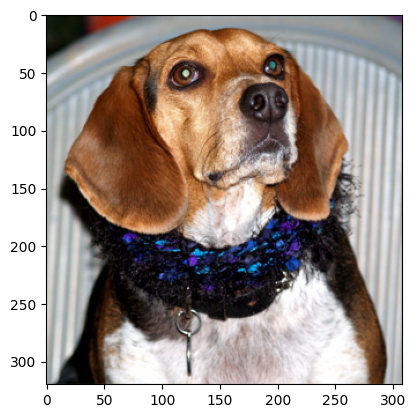

In [2]:
x = imread('beagle.jpeg').to(DEVICE)
x = rr.resize(x, 0.5)
imshow(x)

## Function that tries to learn continuous multiscale bicubic kernel 

In [3]:
def learn_bicubic(high_res, kernel_shape, channels_each_layer, 
                  num_iters, leran_rate, sf_min, sf_max,
                  pos_embed_size=None, pos_embed_scale=None, log_interval=10):
    k_net = KernelMLP(channels_each_layer, pos_embed_size, pos_embed_scale).to(high_res.device)
    opt = torch.optim.Adam(k_net.parameters(), lr=leran_rate)
    sf_min = torch.tensor(sf_min, device=high_res.device)
    sf_max = torch.tensor(sf_max, device=high_res.device)
    for i in range(num_iters):
        sf = torch.rand(2, device=high_res.device) * (sf_max - sf_min) + sf_min
        high_res_crop, _ = multires_rand_crop(high_res, high_res, 128)
        low_res = rr.resize(high_res_crop, (1/sf).tolist())
        
        loss = one_k_opt_step(high_res_crop, low_res, k_net, kernel_shape, opt, sf=sf)
        
        if i % log_interval == 0:
            print(f'Iter {i}, loss={loss.item()}')
    return k_net

## Train

In [4]:
kmlp = learn_bicubic(x, 
                     kernel_shape=8, 
                     channels_each_layer=[256]*3,
                     pos_embed_size=None,
                     pos_embed_scale=None,
                     num_iters=500,
                     leran_rate=1e-3,
                     sf_min=(2, 2),
                     sf_max=(2.2, 2.2),
                     log_interval=50)


/home/ashocher/anaconda3/envs/edm/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380164/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iter 0, loss=0.026247385889291763
Iter 50, loss=0.0002145904436474666
Iter 100, loss=0.00016395583224948496
Iter 150, loss=0.00027805811259895563
Iter 200, loss=0.00027415272779762745
Iter 250, loss=0.000226869888138026
Iter 300, loss=0.0003238460631109774
Iter 350, loss=0.00027077324921265244
Iter 400, loss=0.00013540587679017335
Iter 450, loss=0.00015836767852306366


## Visualize kernels

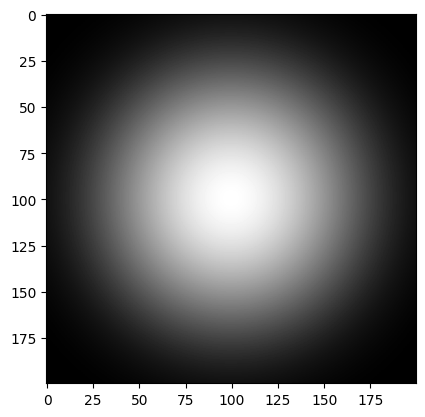

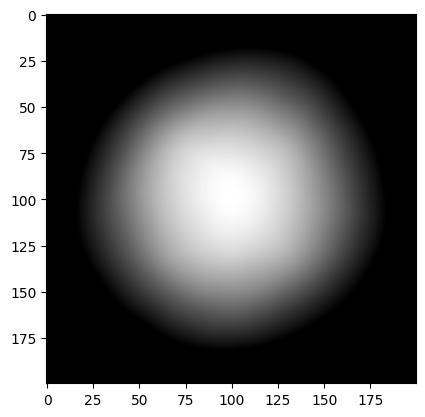

Saved real_cubic.gif!
Saved est_cubic.gif!


In [5]:
max_sf = 4

sfs_x = [torch.linspace(1, max_sf, 20, device=DEVICE)]
sfs_x.append(torch.linspace(max_sf, 2, 20, device=DEVICE))
sfs_x.append(torch.linspace(2, max_sf, 20, device=DEVICE))
sfs_x.append(torch.linspace(max_sf, 1, 20, device=DEVICE))
sfs_x = torch.cat(sfs_x)

sfs_y = [torch.linspace(1, max_sf, 20, device=DEVICE)]
sfs_y.append(torch.linspace(max_sf, 2, 20, device=DEVICE))
sfs_y.append(torch.linspace(2, 2, 20, device=DEVICE))
sfs_y.append(torch.linspace(2, max_sf, 20, device=DEVICE))
sfs_y = torch.cat(sfs_y)

sfs = torch.stack([sfs_x, sfs_y], 1)

vis_kernel(cubic_aa, (4,4), (2, 2), sz=200, device=DEVICE)
vis_kernel(kmlp, (4,4), (2, 2), sz=200, device=DEVICE)

vis_kernel_over_scales(cubic_aa, (8,8), sfs, filename='real_cubic.gif', sz=200, device=DEVICE)
vis_kernel_over_scales(kmlp, (8,8), sfs, filename='est_cubic.gif',sz=200, device=DEVICE)